In [152]:
from pathlib import Path
import argparse
import json
import logging
import sqlite3
import tarfile
import os
import tempfile
from io import BytesIO
import struct
import logging
from dotenv import load_dotenv

from PIL import Image
from tqdm.auto import tqdm
import clip
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from union_find import UnionFind
from schema import DB
from schema import setup_db


%load_ext autoreload
%autoreload 2

load_dotenv()
setup_db()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
!uv add matplotlib

Resolved 137 packages in 290ms                                       
Prepared 4 packages in 186ms                                             
Installed 6 packages in 9ms                                 
 + contourpy==1.3.3
 + cycler==0.12.1
 + fonttools==4.60.1
 + kiwisolver==1.4.9
 + matplotlib==3.10.7
 + pyparsing==3.2.5


In [ ]:
!uv pip install git+https://github.com/openai/CLIP.git

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
model, preprocess = clip.load("ViT-B/32", device=device)

# image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
# text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

# with torch.no_grad():
#     image_features = model.encode_image(image)
#     text_features = model.encode_text(text)
    
#     logits_per_image, logits_per_text = model(image, text)
#     probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [ ]:
%%time
# Compute embeddings for all hot dogs.
with tarfile.open(FOOD_TAR_PATH, 'r:gz') as tar:
    for idx, row in tqdm(df[df['label'] == 'hot_dog'].iterrows()):
        member = tar.getmember(row['path'])
        with tar.extractfile(member) as member_file:
            image_file = BytesIO(member_file.read())
            image = preprocess(Image.open(image_file)).unsqueeze(0).to(device)
            with torch.no_grad():
                image_features = model.encode_image(image)
            v = image_features[0].cpu().numpy().tolist()
            with sqlite3.connect(DB) as conn:
                sql = 'UPDATE embeddings SET embedding = ? WHERE id = ?'
                conn.execute(sql, (struct.pack('512f', *v), row['id']))        

In [75]:
with sqlite3.connect(DB) as conn:
    sql = 'SELECT id FROM embeddings WHERE embedding IS NOT NULL'
    known_ids = set(pd.read_sql(sql, conn)['id'].tolist())
print(len(known_ids))    

101000


In [74]:
%%time
# Compute embeddings for all images.
with tarfile.open(FOOD_TAR_PATH, 'r:gz') as tar:
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        if row['id'] in known_ids:
            continue
        member = tar.getmember(row['path'])
        try:
            with tar.extractfile(member) as member_file:
                image_file = BytesIO(member_file.read())
                image = preprocess(Image.open(image_file)).unsqueeze(0).to(device)
                with torch.no_grad():
                    image_features = model.encode_image(image)
                v = image_features[0].cpu().numpy().tolist()
                with sqlite3.connect(DB) as conn:
                    sql = 'UPDATE embeddings SET embedding = ? WHERE id = ?'
                    conn.execute(sql, (struct.pack('512f', *v), row['id']))        
        except Exception as ex:
            logging.error(ex)
            logging.error(row['path'])

  0%|          | 0/101000 [00:00<?, ?it/s]

CPU times: user 12min 20s, sys: 1min 53s, total: 14min 14s
Wall time: 1h 55min 36s


OSError: [Errno 9] Bad file descriptor

In [80]:
with sqlite3.connect(DB) as conn:
    sql = 'SELECT * FROM embeddings'
    embeddings_df = pd.read_sql(sql, conn)
embeddings_df['embedding'] = embeddings_df['embedding'].map(lambda x: np.array(struct.unpack('512f', x)))
embeddings_df

,id,path,label,embedding
0,53,food-101/images/beet_salad/53.jpg,beet_salad,"[-0.2138671875, 0.14208984375, 0.556640625, 0...."
1,122,food-101/images/croque_madame/122.jpg,croque_madame,"[-0.0216827392578125, 0.2269287109375, -0.2834..."
2,125,food-101/images/omelette/125.jpg,omelette,"[0.350830078125, 0.7265625, -0.04364013671875,..."
3,134,food-101/images/apple_pie/134.jpg,apple_pie,"[0.182861328125, 0.6865234375, 0.0397338867187..."
4,176,food-101/images/omelette/176.jpg,omelette,"[-0.0645751953125, 0.31787109375, -0.283691406..."
...,...,...,...,...
100995,3924575,food-101/images/gyoza/3924575.jpg,gyoza,"[0.252685546875, 0.245849609375, -0.1638183593..."
100996,3924588,food-101/images/tiramisu/3924588.jpg,tiramisu,"[0.048004150390625, 0.453857421875, -0.0444946..."
100997,3924668,food-101/images/clam_chowder/3924668.jpg,clam_chowder,"[0.082763671875, 0.4443359375, 0.262939453125,..."
100998,3924720,food-101/images/scallops/3924720.jpg,scallops,"[0.134765625, 0.455078125, 0.2484130859375, 0...."


In [81]:
def cosine_similarity(embedding1, embedding2):
    """Compute cosine similarity between two embeddings."""
    # Flatten embeddings if they are multidimensional
    emb1 = np.array(embedding1).flatten()
    emb2 = np.array(embedding2).flatten()

    # Compute cosine similarity
    dot_product = np.dot(emb1, emb2)
    norm1 = np.linalg.norm(emb1)
    norm2 = np.linalg.norm(emb2)

    if norm1 == 0 or norm2 == 0:
        return 0.0

    return dot_product / (norm1 * norm2)

In [90]:
hotdog_df = embeddings_df[embeddings_df['label'] == 'hot_dog']
M = np.zeros([1000, 1000])
for i, v1 in enumerate(hotdog_df['embedding'].tolist()):
    for j, v2 in enumerate(hotdog_df['embedding'].tolist()):
        M[j][i] = cosine_similarity(v1, v2)

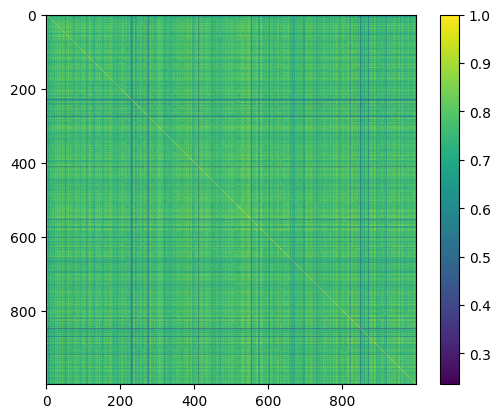

In [97]:
plt.imshow(M)
plt.colorbar()

In [114]:
with open('labels.txt') as f:
    label_txt = [l.strip() for l in f.readlines()]
with open('classes.txt') as f:
    classes_txt = [l.strip() for l in f.readlines()]    

In [105]:
text = clip.tokenize(label_txt).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)



In [115]:
classes_txt[np.argmax(probs)]

'spaghetti_bolognese'

In [147]:
predictions = {}
for idx, row in tqdm(embeddings_df.iterrows(), total=len(embeddings_df)):
    v1 = row['embedding']
    sims = [cosine_similarity(v1, t.cpu().numpy())  for t in text_features]
    predictions[row['id']] = classes_txt[np.argmax(sims)]

  0%|          | 0/101000 [00:00<?, ?it/s]

In [153]:
with sqlite3.connect(DB) as conn:
    sql = 'INSERT OR IGNORE INTO predictions (id, predicted_label) VALUES (?, ?)'
    conn.executemany(sql, [(k, v) for k, v in predictions.items()])

In [156]:
with sqlite3.connect(DB) as conn:
    sql = '''
    SELECT embeddings.*, predicted_label 
    FROM embeddings
    LEFT JOIN predictions
        USING (id)
    '''
    combined_df = pd.read_sql(sql, conn)
combined_df['embedding'] = combined_df['embedding'].map(lambda x: np.array(struct.unpack('512f', x)))
combined_df

,id,path,label,embedding,predicted_label
0,53,food-101/images/beet_salad/53.jpg,beet_salad,"[-0.2138671875, 0.14208984375, 0.556640625, 0....",seaweed_salad
1,122,food-101/images/croque_madame/122.jpg,croque_madame,"[-0.0216827392578125, 0.2269287109375, -0.2834...",croque_madame
2,125,food-101/images/omelette/125.jpg,omelette,"[0.350830078125, 0.7265625, -0.04364013671875,...",omelette
3,134,food-101/images/apple_pie/134.jpg,apple_pie,"[0.182861328125, 0.6865234375, 0.0397338867187...",apple_pie
4,176,food-101/images/omelette/176.jpg,omelette,"[-0.0645751953125, 0.31787109375, -0.283691406...",omelette
...,...,...,...,...,...
100995,3924575,food-101/images/gyoza/3924575.jpg,gyoza,"[0.252685546875, 0.245849609375, -0.1638183593...",gyoza
100996,3924588,food-101/images/tiramisu/3924588.jpg,tiramisu,"[0.048004150390625, 0.453857421875, -0.0444946...",panna_cotta
100997,3924668,food-101/images/clam_chowder/3924668.jpg,clam_chowder,"[0.082763671875, 0.4443359375, 0.262939453125,...",lobster_bisque
100998,3924720,food-101/images/scallops/3924720.jpg,scallops,"[0.134765625, 0.455078125, 0.2484130859375, 0....",caesar_salad


In [158]:
(combined_df['label'] == combined_df['predicted_label']).sum() / len(combined_df)

np.float64(0.7790495049504951)

In [165]:
mask = combined_df['label'] == 'hot_dog'
accuracy = (combined_df[mask]['label'] == combined_df[mask]['predicted_label']).sum() / len(combined_df[mask])
print(accuracy)
combined_df[mask].groupby('predicted_label').count().sort_values('id', ascending=False)

0.731


,id,path,label,embedding
predicted_label,,,,
hot_dog,731,731,731,731
lobster_roll_sandwich,84,84,84,84
pulled_pork_sandwich,54,54,54,54
club_sandwich,15,15,15,15
breakfast_burrito,11,11,11,11
grilled_cheese_sandwich,10,10,10,10
french_fries,10,10,10,10
falafel,8,8,8,8
poutine,6,6,6,6


In [166]:
mask = combined_df['predicted_label'] == 'hot_dog'
accuracy = (combined_df[mask]['label'] == combined_df[mask]['predicted_label']).sum() / len(combined_df[mask])
print(accuracy)
combined_df[mask].groupby('label').count().sort_values('id', ascending=False)

0.9643799472295514


,id,path,embedding,predicted_label
label,,,,
hot_dog,731,731,731,731
hamburger,8,8,8,8
pulled_pork_sandwich,4,4,4,4
chocolate_cake,2,2,2,2
lobster_roll_sandwich,2,2,2,2
beef_carpaccio,1,1,1,1
chicken_wings,1,1,1,1
club_sandwich,1,1,1,1
french_toast,1,1,1,1


In [126]:
with torch.no_grad():
    image = torch.from_numpy(embeddings_df.iloc[0]['embedding']).unsqueeze(0)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 512]

In [113]:
df[df['id'] == row['id']]

,path,id,label
100999,food-101/images/spaghetti_bolognese/3306521.jpg,3306521,spaghetti_bolognese


In [128]:
image_features.shape

torch.Size([1, 512])